# Manifold, clustering and annotations

**Note**: clustering result depend on package versions. Using newer versions of e.g. scanpy or louvain may result in slightly different clusters.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as pl
import scanpy.api as sc
import matplotlib as mpl
from matplotlib import rcParams

import seaborn as sns
import scipy as sci

import gseapy as gp
from xlrd import XLRDError
import xlsxwriter

/Users/sophie/miniconda3/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
sc.settings.verbosity = 3
sc.logging.print_versions()

scanpy==1.0.4+92.g9a754bb.dirty anndata==0.5.10 numpy==1.14.2 scipy==1.0.1 pandas==0.22.0 scikit-learn==0.19.1 statsmodels==0.8.0 python-igraph==0.7.1 louvain==0.6.1 


In [3]:
sc.settings.writedir='./data/'

In [4]:
sc.set_figure_params(vector_friendly=True,color_map='RdBu_r',dpi_save=600)

In [5]:
adata_all = sc.read('./data/adata_corrected.h5')

## single cell manifold and embedding

### Highly variable genes

/Users/sophie/code/scanpy/scanpy/preprocessing/simple.py:355: RuntimeWarning: invalid value encountered in greater_equal
  gene_subset = df['dispersion_norm'].values >= disp_cut_off


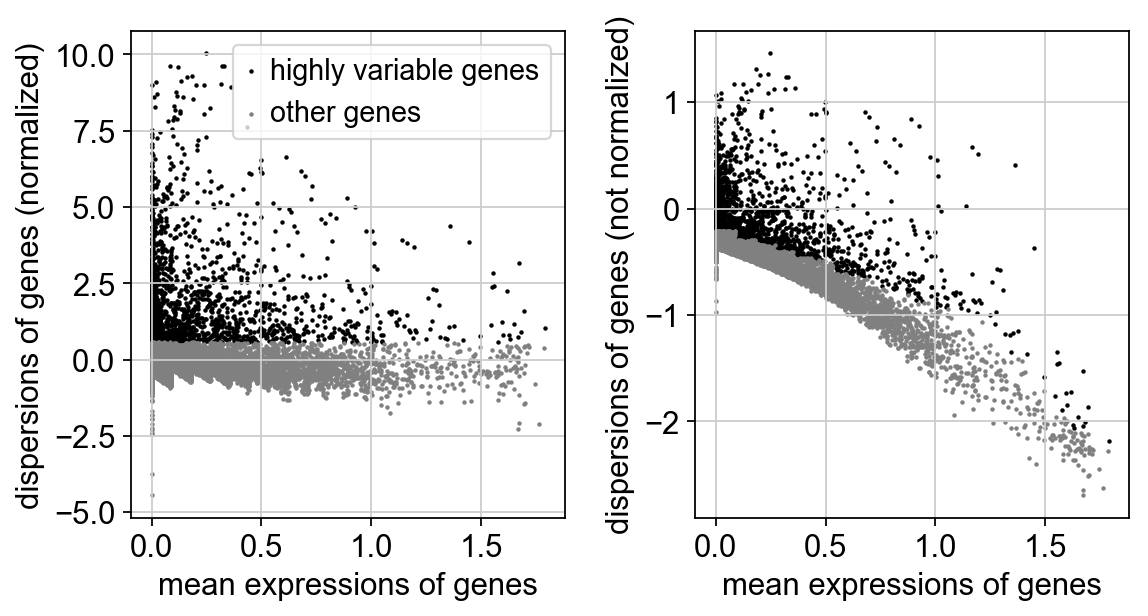

In [6]:
filter_result = sc.pp.filter_genes_dispersion(adata_all.X, n_top_genes=2000)
sc.pl.filter_genes_dispersion(filter_result, log=False)

In [7]:
# subset to hvg genes
adata_all_hvg = adata_all[:, filter_result.gene_subset]

In [8]:
print(adata_all.n_vars)
print(adata_all_hvg.n_vars)

15723
2000


### PCA and kNN

In [9]:
sc.pp.pca(adata_all_hvg)

In [10]:
sc.pp.neighbors(adata_all_hvg, n_neighbors=25, n_pcs=50, method='gauss')

computing neighbors
    using 'X_pca' with n_pcs = 50
    finished (0:00:34.85) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix


### UMAP

In [11]:
sc.tl.umap(adata_all_hvg, min_dist=0.5)

computing UMAP
    finished (0:00:56.10) --> added
    'X_umap', UMAP coordinates (adata.obsm)


## Iterative clustering and annotation

In [12]:
sc.tl.louvain(adata_all_hvg, resolution=0.6)

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:09.48) --> found 14 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)


In [16]:
adata_all_hvg = sc.read('../data/scanpy/adata_crypt_processed_hvg.h5')

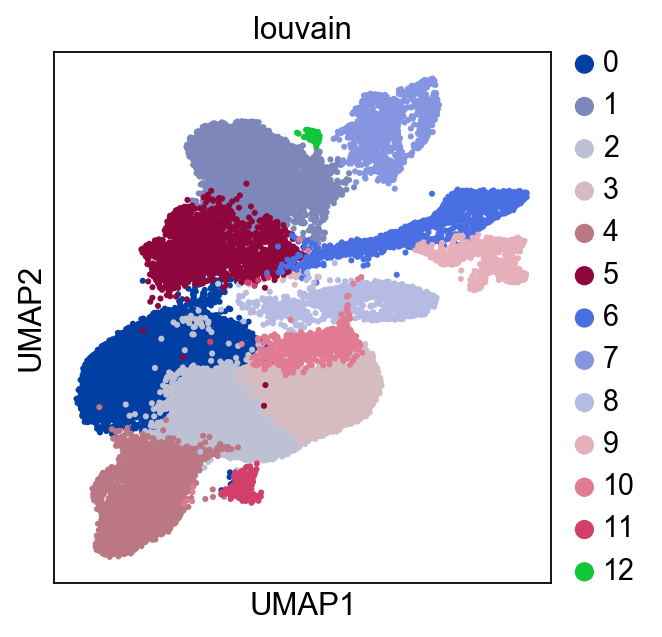

In [17]:
sc.pl.umap(adata_all_hvg, color='louvain', size=30)

In [18]:
adata_all.obs['louvain'] = adata_all_hvg.obs['louvain']

### Refine cell type clustering

#### ISC, EEC and Goblet progenitors

In [19]:
sc.tl.louvain(adata_all_hvg, resolution=0.15, restrict_to=('louvain',['0']), key_added='prog_refined_1')

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:01.61) --> found 2 clusters and added
    'prog_refined_1', the cluster labels (adata.obs, categorical)


/Users/sophie/miniconda3/lib/python3.5/site-packages/pandas/core/indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
/Users/sophie/miniconda3/lib/python3.5/site-packages/pandas/core/indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
/Users/sophie/code/scanpy/scanpy/tools/louvain.py:131: FutureWarning: specifying 'categories' or 'ordered' in .astype() is deprecated; pass a CategoricalDtype instead
  'category', categories=natsorted(adata.obs[key_added].unique()))


In [20]:
sc.tl.louvain(adata_all_hvg, resolution=0.15, restrict_to=('prog_refined_1',['0,1']), key_added='prog_refined_2')

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.38) --> found 2 clusters and added
    'prog_refined_2', the cluster labels (adata.obs, categorical)


In [21]:
sc.tl.louvain(adata_all_hvg, resolution=0.2, restrict_to=('prog_refined_2',['5']), key_added='prog_refined_3')

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.40) --> found 3 clusters and added
    'prog_refined_3', the cluster labels (adata.obs, categorical)


In [22]:
sc.tl.louvain(adata_all_hvg, resolution=0.8, restrict_to=('prog_refined_3',['5,2']), key_added='prog_refined_4')

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.23) --> found 5 clusters and added
    'prog_refined_4', the cluster labels (adata.obs, categorical)


In [23]:
adata_all.obs['prog_refined_4'] = adata_all_hvg.obs['prog_refined_4']

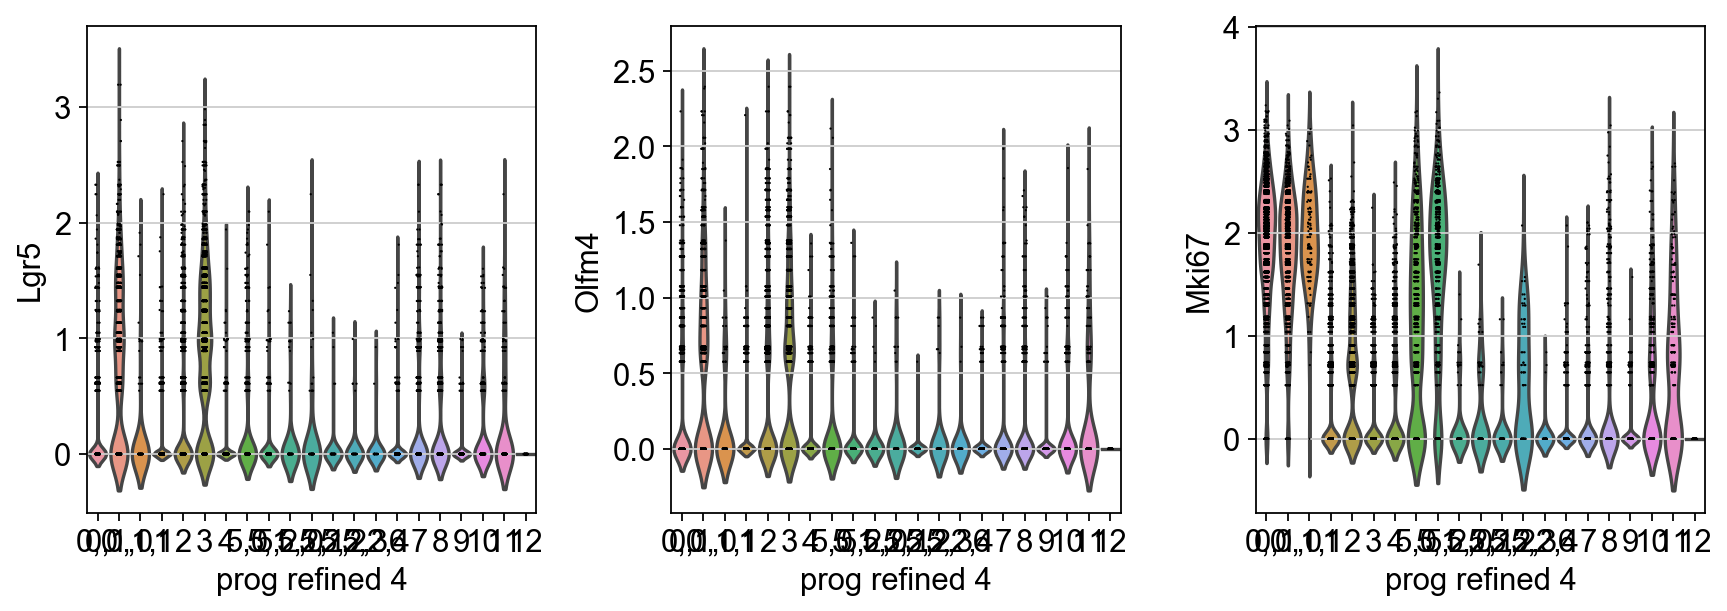

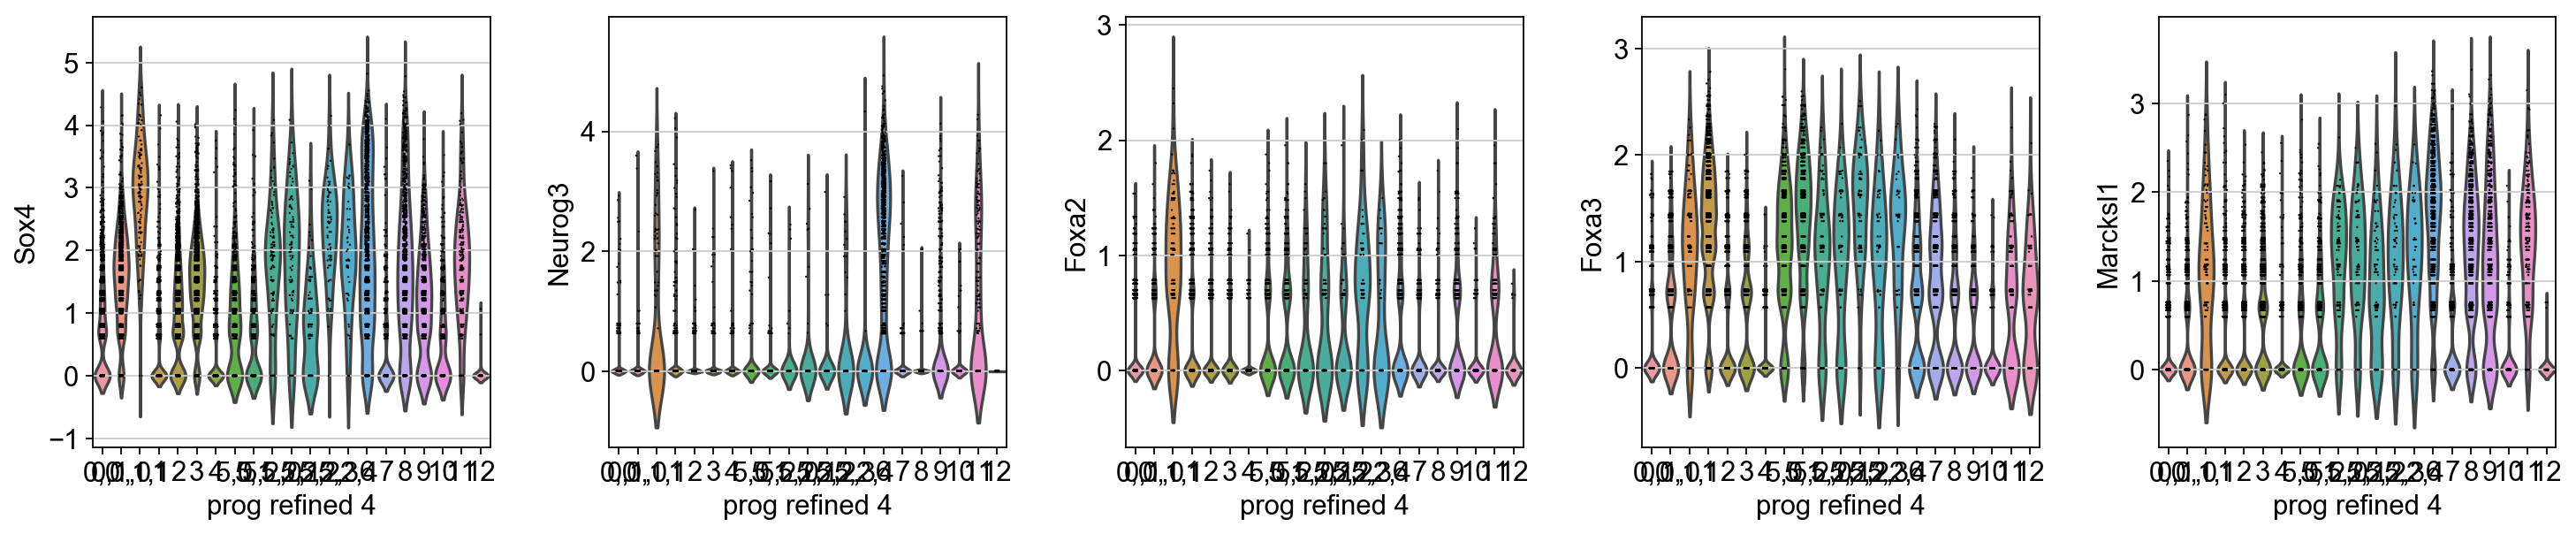

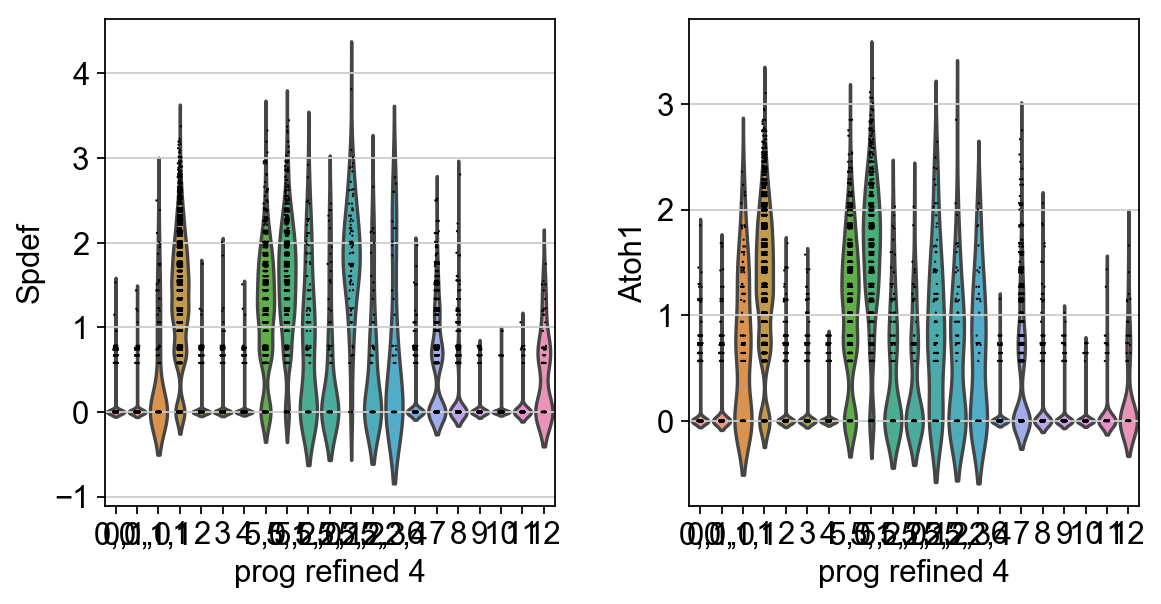

In [24]:
# ISC and cell cycle
sc.pl.violin(adata_all, keys=['Lgr5', 'Olfm4', 'Mki67'], groupby='prog_refined_4')
# endocrine
sc.pl.violin(adata_all, keys=['Sox4', 'Neurog3', 'Foxa2', 'Foxa3', 'Marcksl1'], groupby='prog_refined_4')
# goblet
sc.pl.violin(adata_all, keys=['Spdef','Atoh1'], groupby='prog_refined_4')

#### ISC and enterocyte progenitor

In [25]:
sc.tl.louvain(adata_all_hvg,resolution=0.7,restrict_to=('prog_refined_4',['2']),key_added='prog_refined_45')
sc.tl.louvain(adata_all_hvg,resolution=0.7,restrict_to=('prog_refined_45',['0,1,0']),key_added='prog_refined_5')

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.74) --> found 8 clusters and added
    'prog_refined_45', the cluster labels (adata.obs, categorical)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.29) --> found 5 clusters and added
    'prog_refined_5', the cluster labels (adata.obs, categorical)


In [26]:
adata_all.obs['prog_refined_5'] = adata_all_hvg.obs['prog_refined_5']

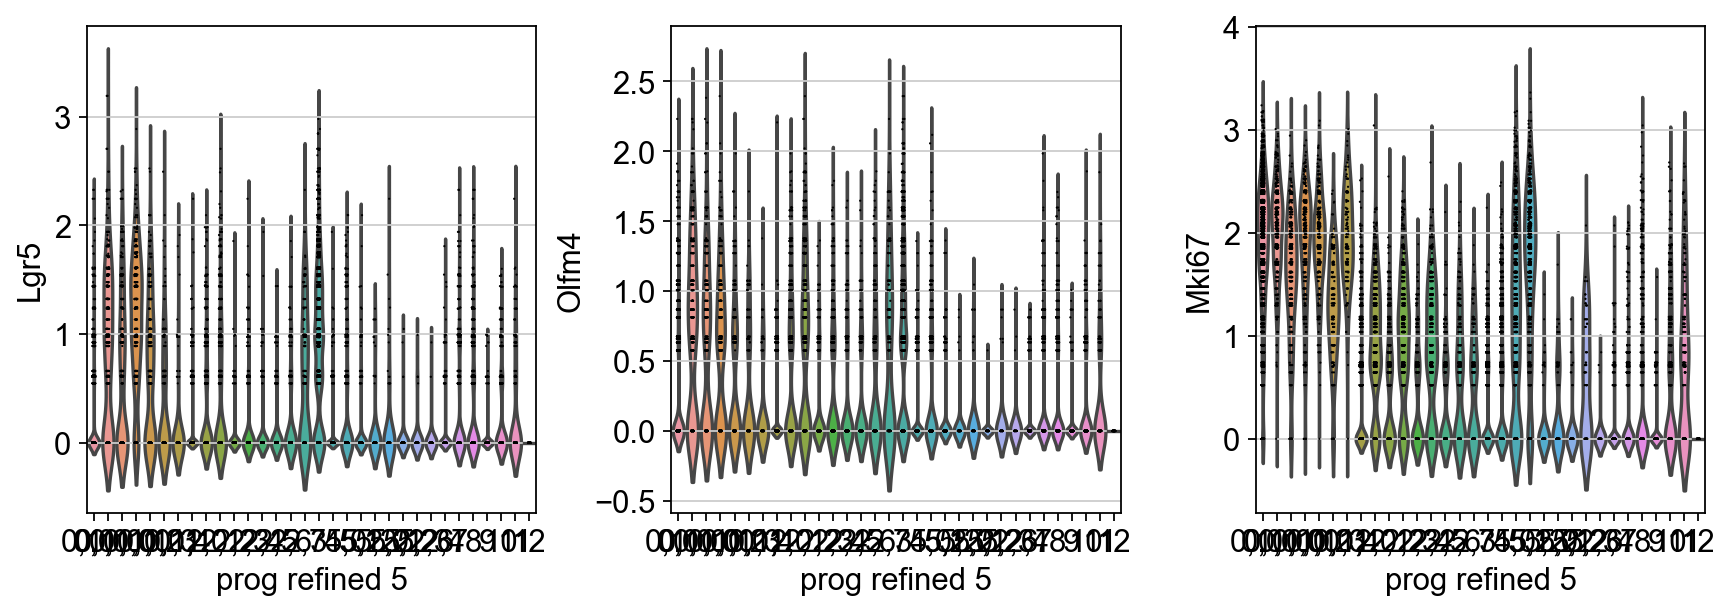

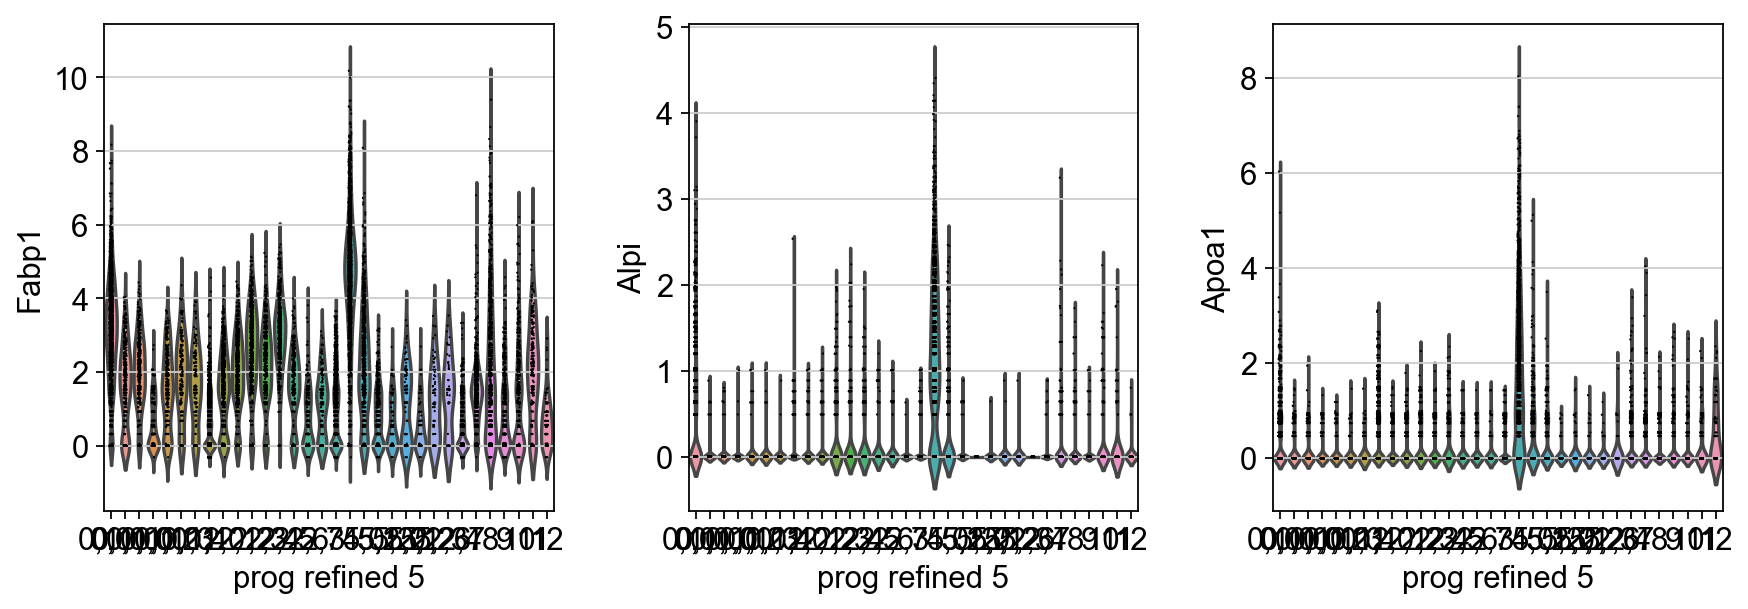

In [27]:
# ISC and cell cycle
sc.pl.violin(adata_all, keys=['Lgr5', 'Olfm4', 'Mki67'], groupby='prog_refined_5')

# enterocyte
sc.pl.violin(adata_all, keys=['Fabp1', 'Alpi', 'Apoa1'], groupby='prog_refined_5')

#### Tuft progenitor

In [28]:
sc.tl.louvain(adata_all_hvg, restrict_to=('prog_refined_5',['8']), key_added='prog_refined_5', resolution=0.5)

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.42) --> found 5 clusters and added
    'prog_refined_5', the cluster labels (adata.obs, categorical)


#### Paneth progenitor

In [29]:
sc.tl.louvain(adata_all_hvg, resolution=0.9, restrict_to=('prog_refined_5',['7']), key_added='prog_refined_5')

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.29) --> found 8 clusters and added
    'prog_refined_5', the cluster labels (adata.obs, categorical)


#### EE progenitor and EECs

In [30]:
sc.tl.louvain(adata_all_hvg, resolution=0.8, restrict_to=('prog_refined_5',['6']), key_added='prog_eec_refined')

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.36) --> found 7 clusters and added
    'prog_eec_refined', the cluster labels (adata.obs, categorical)


In [31]:
sc.tl.louvain(adata_all_hvg, resolution=0.8, restrict_to=('prog_eec_refined',['9']), key_added='prog_eec_refined')

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.24) --> found 7 clusters and added
    'prog_eec_refined', the cluster labels (adata.obs, categorical)


In [32]:
sc.tl.louvain(adata_all_hvg, resolution=0.7, restrict_to=('prog_eec_refined',['6,0']), key_added='prog_eec_refined')

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.19) --> found 4 clusters and added
    'prog_eec_refined', the cluster labels (adata.obs, categorical)


In [33]:
sc.tl.louvain(adata_all_hvg, resolution=0.5, restrict_to=('prog_eec_refined',['9,1']), key_added='prog_eec_refined')

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.19) --> found 2 clusters and added
    'prog_eec_refined', the cluster labels (adata.obs, categorical)


In [34]:
sc.tl.louvain(adata_all_hvg, resolution=0.7, restrict_to=('prog_eec_refined',['9,6']), key_added='prog_eec_refined')

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.18) --> found 2 clusters and added
    'prog_eec_refined', the cluster labels (adata.obs, categorical)


In [35]:
sc.tl.louvain(adata_all_hvg, resolution=0.7, restrict_to=('prog_eec_refined',['6,0,1']), key_added='prog_eec_refined')

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.20) --> found 3 clusters and added
    'prog_eec_refined', the cluster labels (adata.obs, categorical)


### Merge and annotate cell type clusters

#### major cell types

In [38]:
marker_dict = {'ISC': ['Lgr5', 'Olfm4', 'Axin2', 'Ascl2', 'Slc12a2'],
               'Enterocyte': ['Fabp1', 'Alpi', 'Apoa1', 'Apoa4', 'Lct'],
               'Goblet': ['Muc2', 'Tff3', 'Agr2', 'Spdef', 'Klf4', 'Tff3', 'Ccl9'],
               'Goblet progenitor': ['Spdef', 'Atoh1'],
               'Paneth': ['Lyz1', 'Mmp7', 'Defa17', 'Defa22', 'Ang4'],
               'EEC': ['Neurod1', 'Neurod2', 'Insm1', 'Chga', 'Chgb'],
               'EE progenitor': ['Sox4', 'Neurog3', 'Foxa2', 'Foxa3', 'Marcksl1'],
               'Tuft': ['Dclk1', 'Trpm5', 'Gfi1b', 'Il25']
               }

Paneth


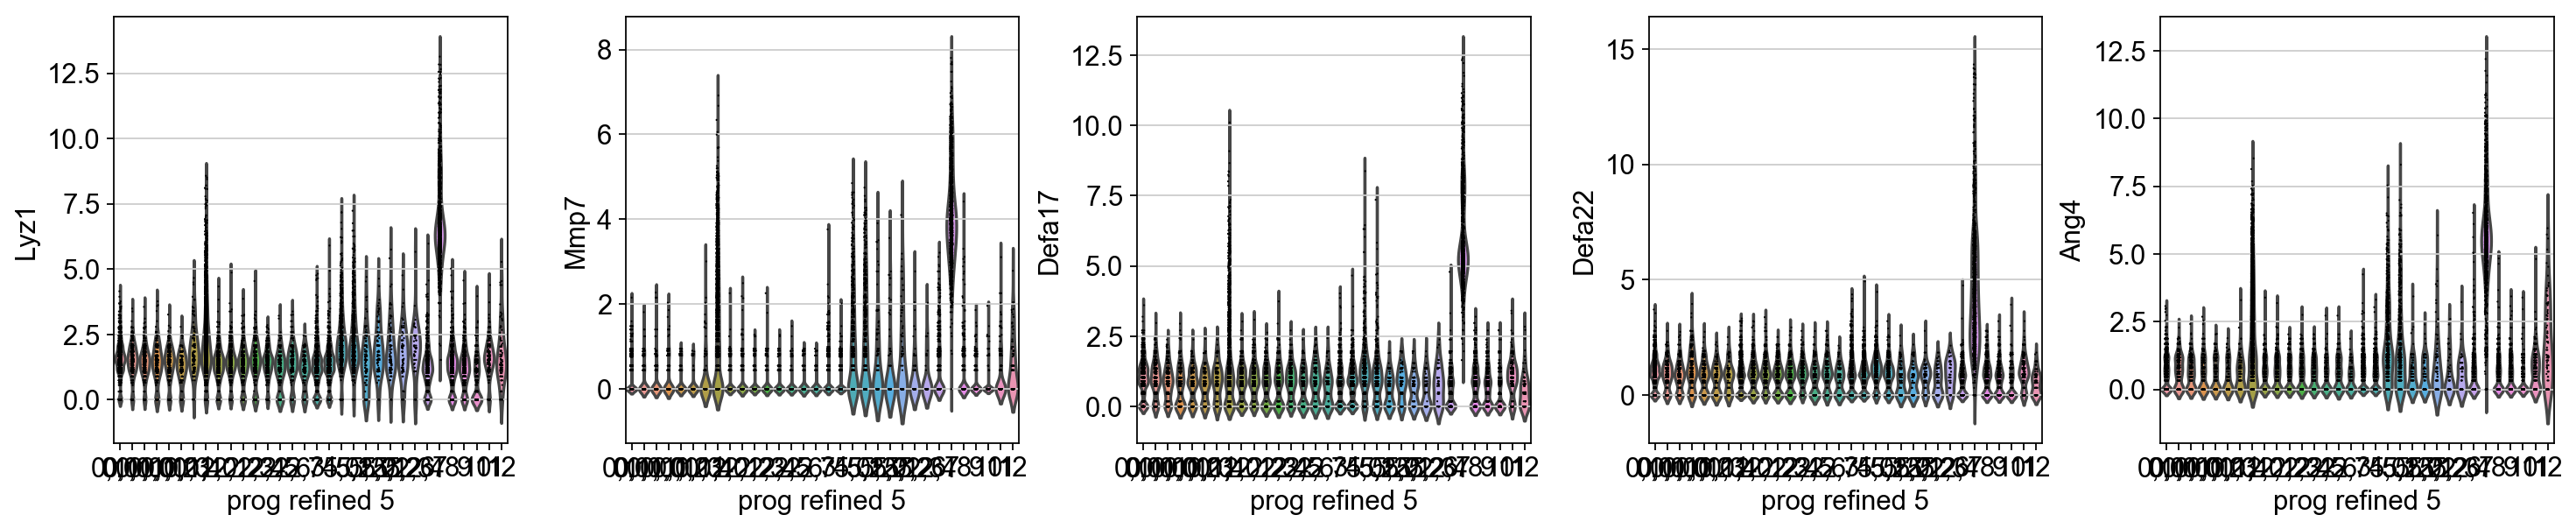

Goblet


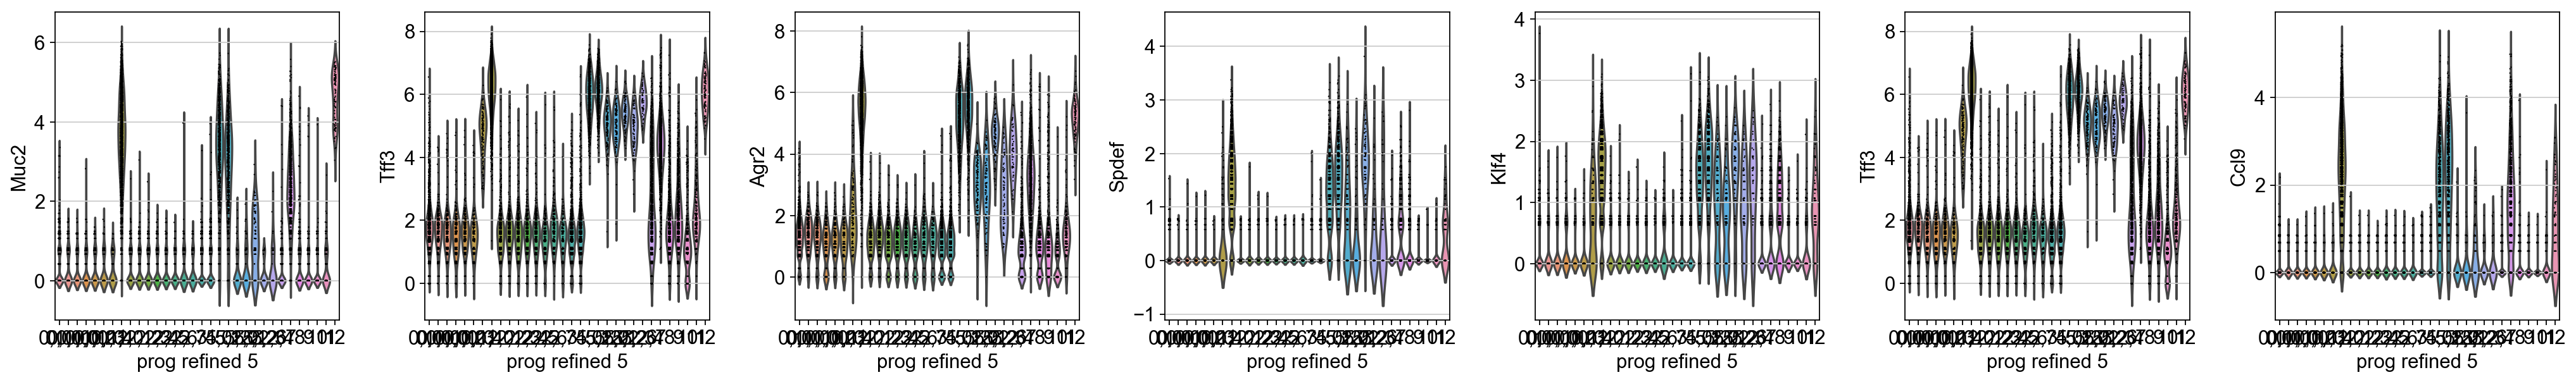

Goblet progenitor


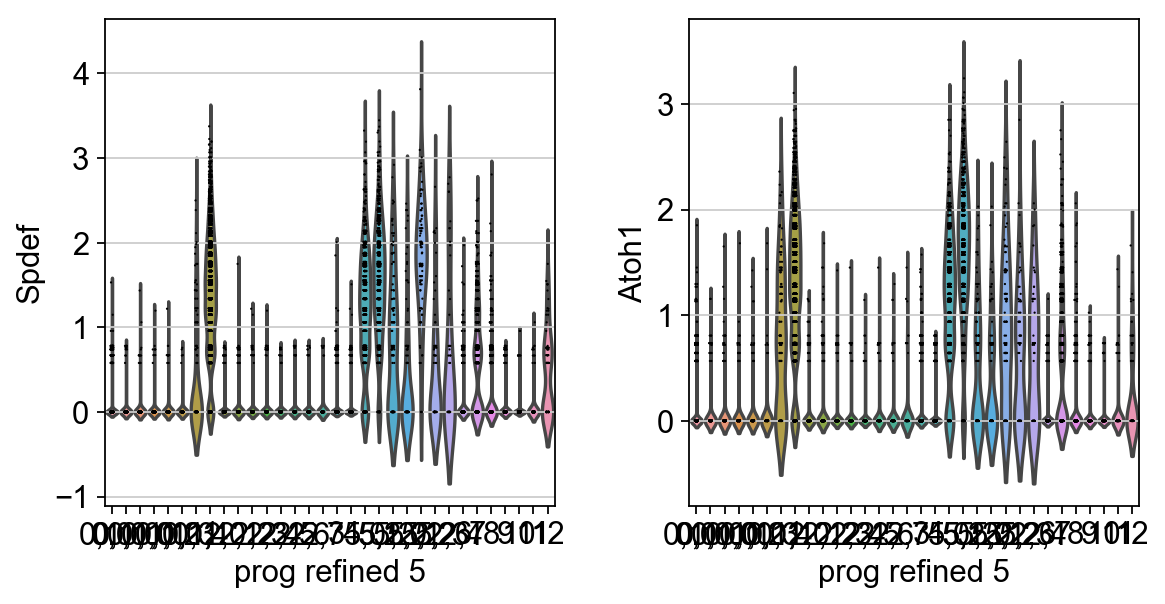

ISC


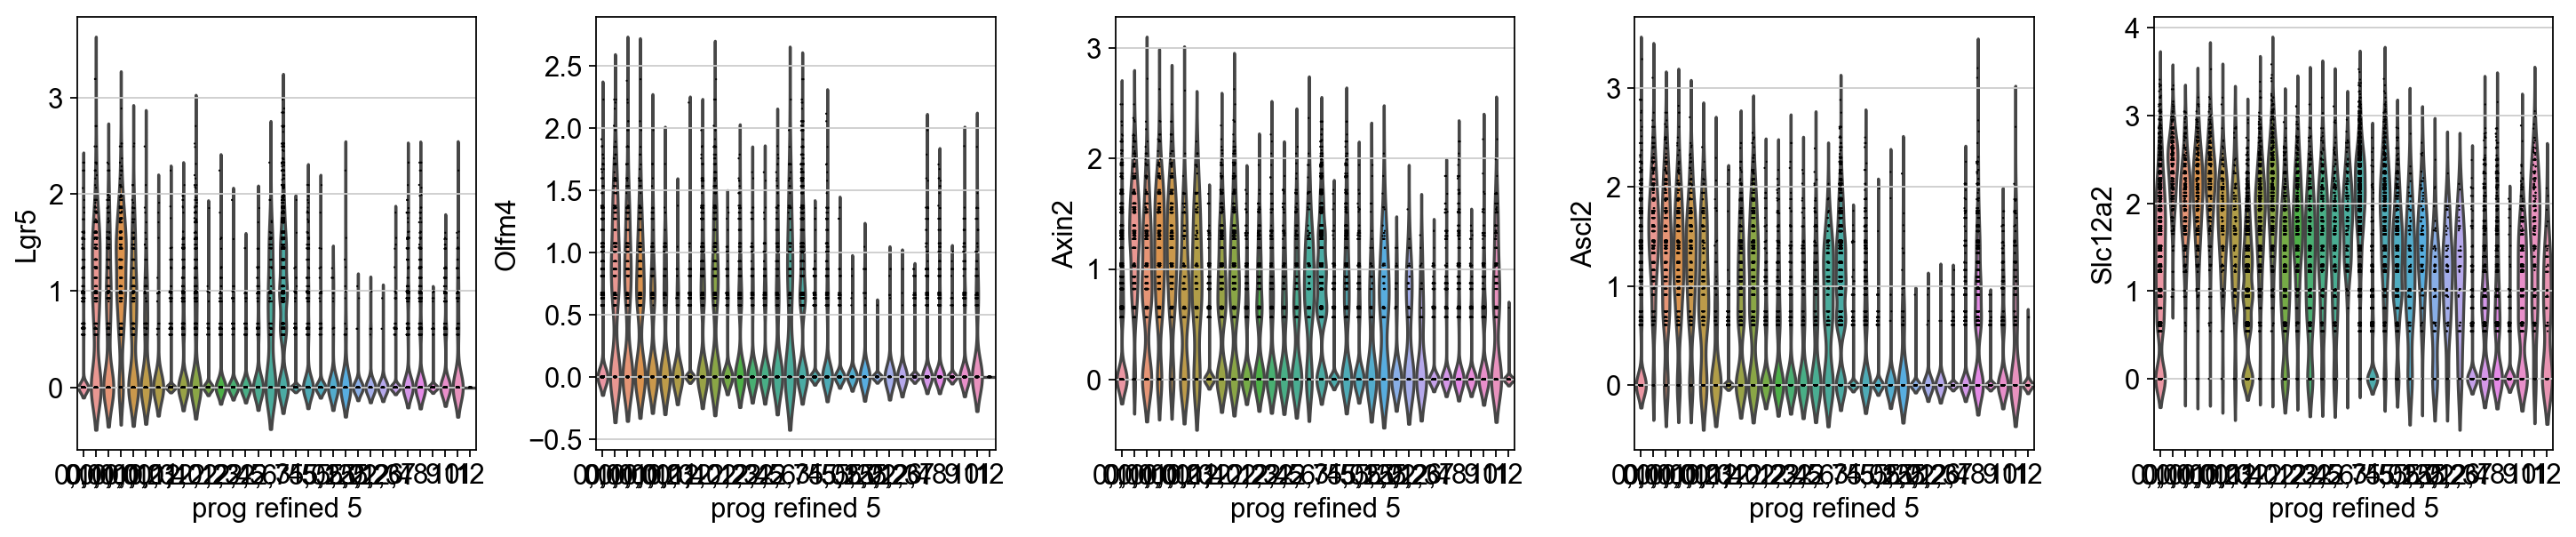

EE progenitor


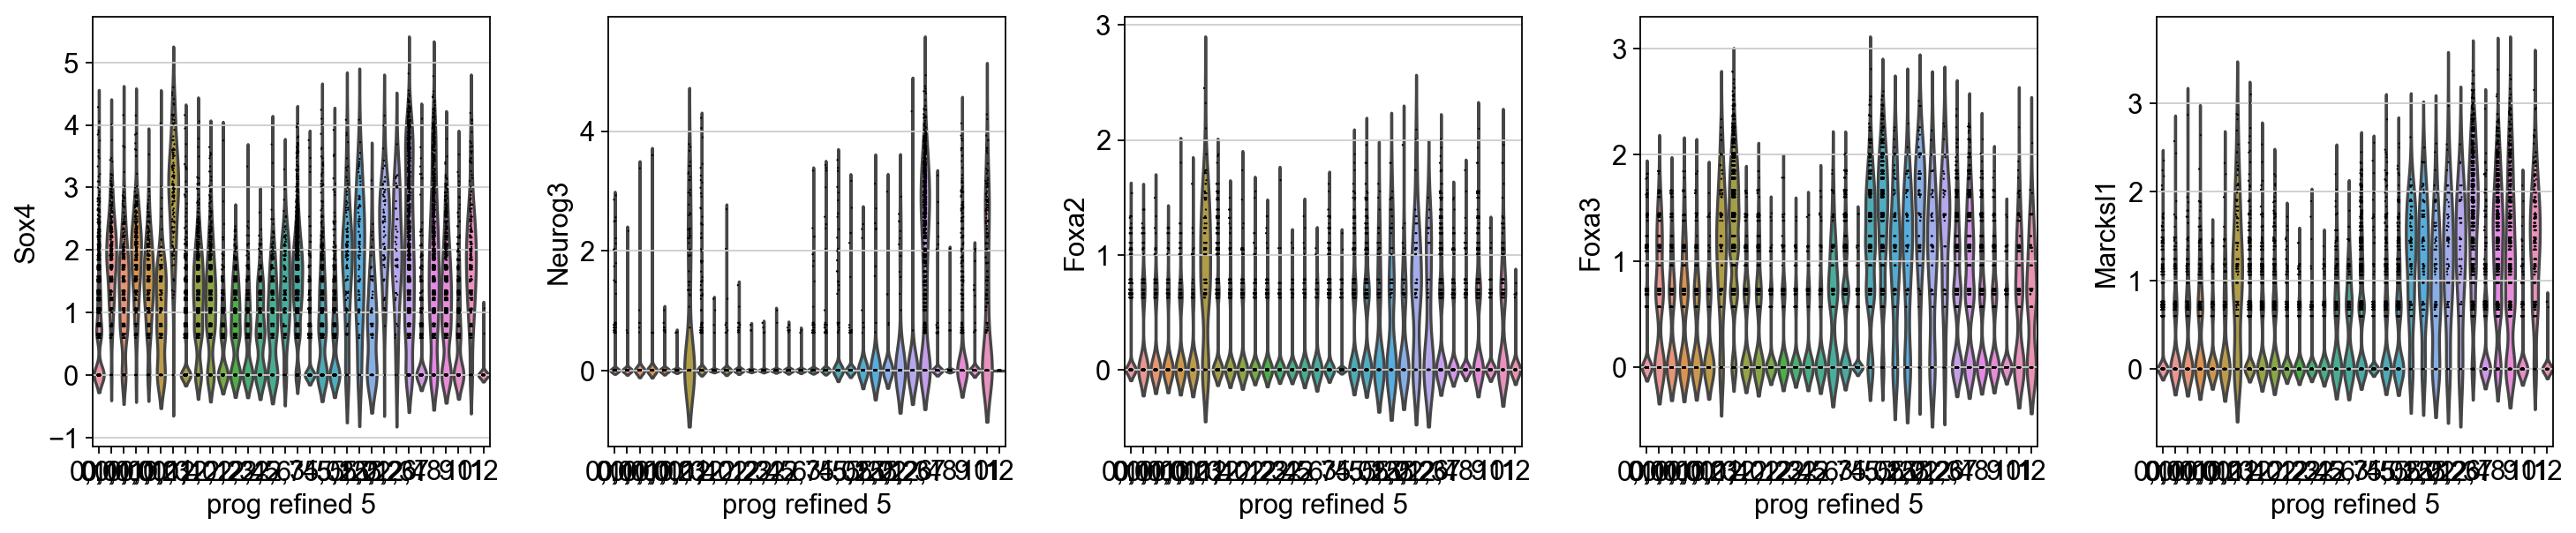

Tuft


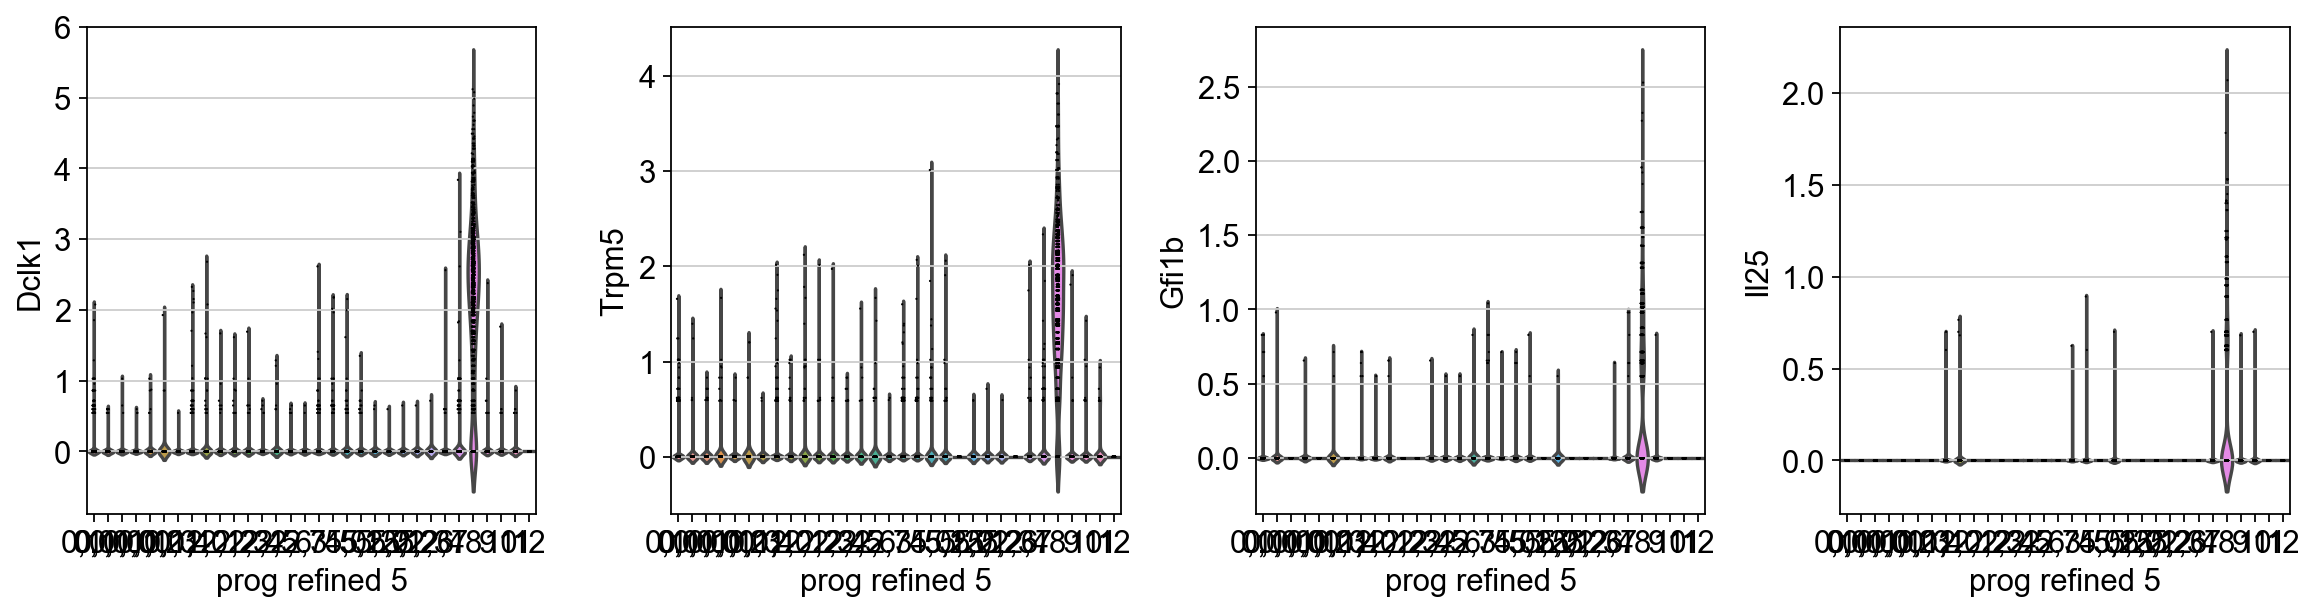

EEC


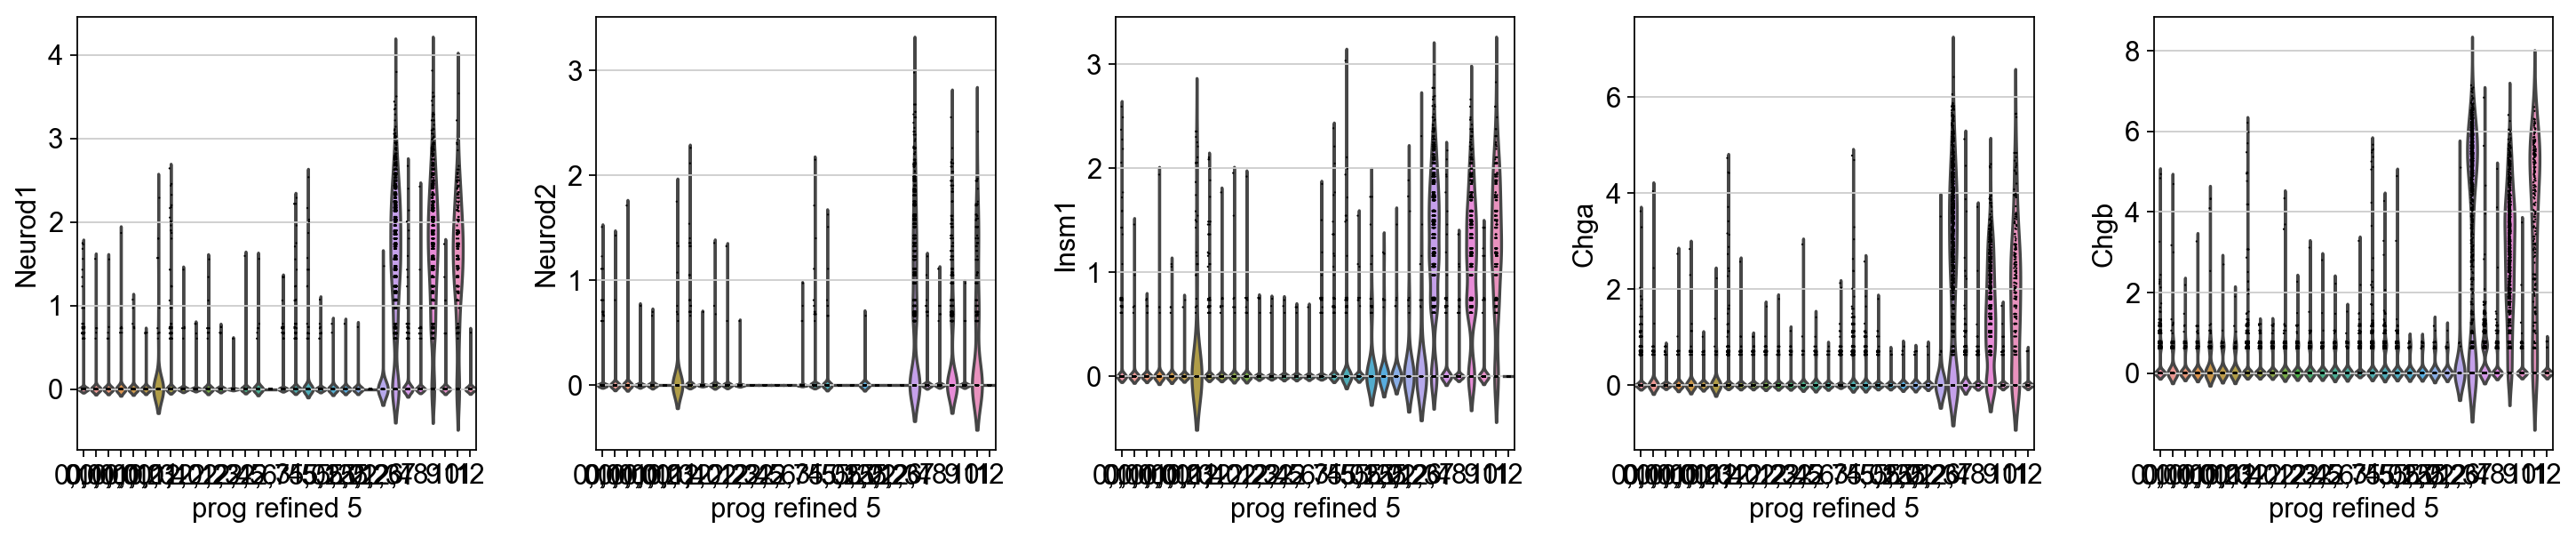

Enterocyte


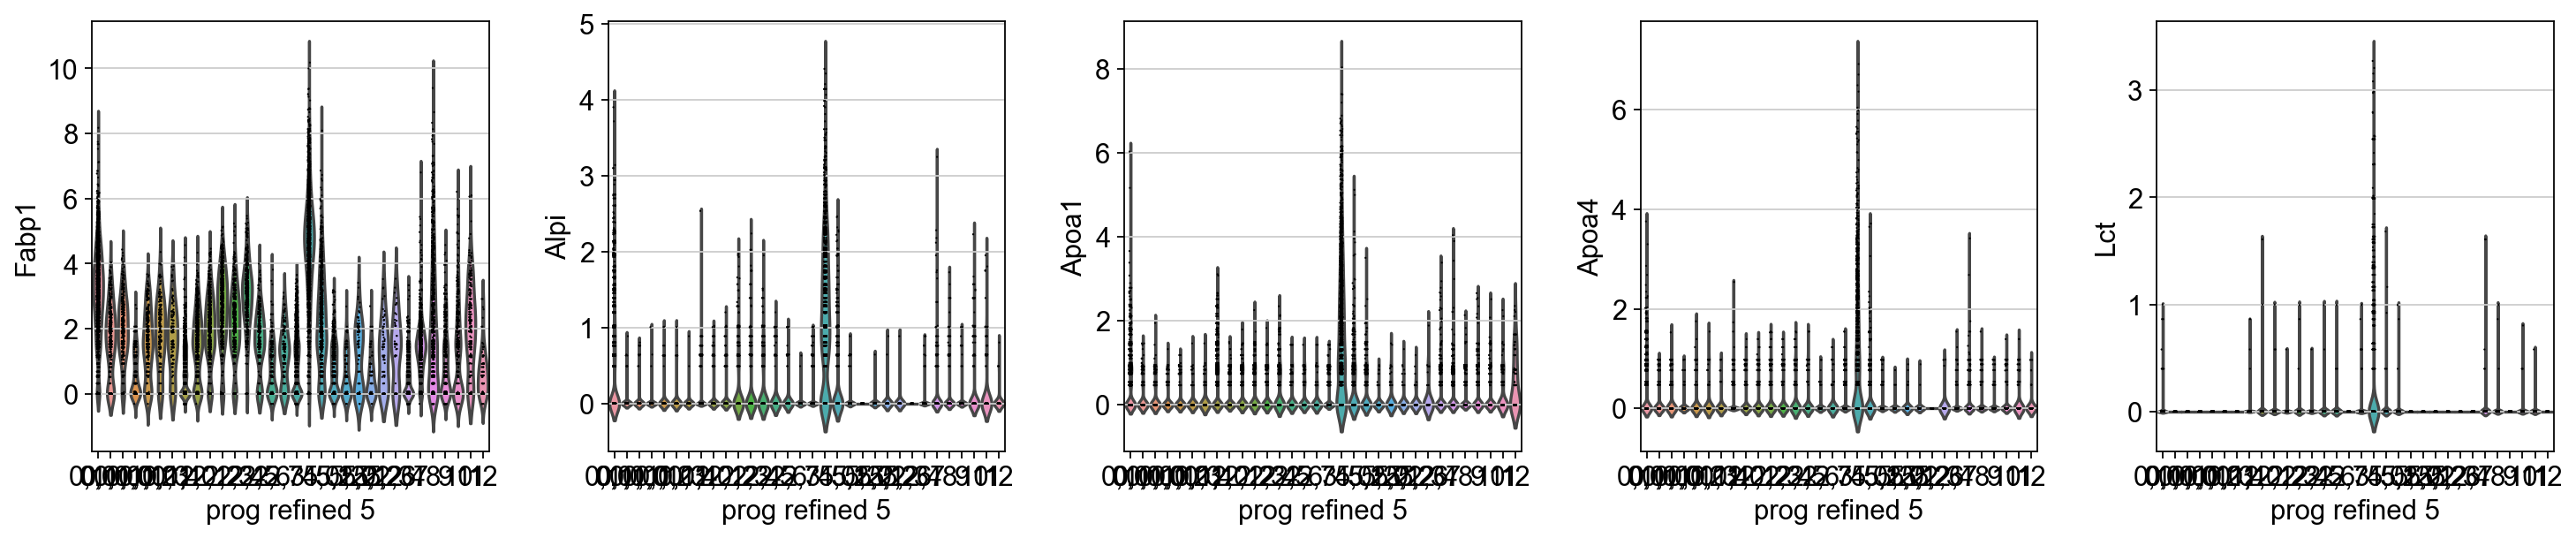

In [39]:
for k,v in marker_dict.items():
    print(k)
    sc.pl.violin(adata_all, keys=v, groupby='prog_refined_5')

In [108]:
map1 = {'ISC': ['3','2,7','0,1,0,2','0,1,0,0'], 
        'not annotated': ['10'], 
        'EEC': ['6','9','0,1,1','5,2,1','5,2,3', '5,2,4', '11'],
        'Enterocyte': ['4', '0,0', '0,1,0,1', '0,1,0,3', '0,1,0,4', '2,2', '2,3', '2,4', '2,5', '2,6', '2,0', '2,1'],
        'Tuft cell': ['8,0', '8,1', '8,2', '8,3', '8,4', '8,5'],
        'Paneth cell': ['7,0', '7,1', '7,2', '7,3', '7,4', '7,5', '7,7', '7,6', '7,8'],
        'Goblet cell': ['1','12','5,0', '5,1', '5,2,0', '5,2,2']}
class_map = {v: k for k,vv in map1.items() for v in vv}

In [109]:
adata_all_hvg.obs['groups_named_broad'] = adata_all_hvg.obs['prog_refined_5']

adata_all_hvg.obs['groups_named_broad'] = [
            class_map[x] if x in class_map.keys() else x
            for x in adata_all_hvg.obs['groups_named_broad'].values
        ]

adata_all_hvg.obs['groups_named_broad'] = adata_all_hvg.obs['groups_named_broad'].astype('category')
adata_all_hvg.obs['groups_named_broad'].cat.reorder_categories(['ISC','Enterocyte', 'Goblet cell','EEC', 'Tuft cell', 'Paneth cell', 'not annotated'], inplace=True)

In [110]:
map1 = {'ISC': ['3','2,7','0,1,0,2','0,1,0,0'], 
        'Enterocyte progenitor': ['0,0', '0,1,0,1', '0,1,0,3', '0,1,0,4', '2,2', '2,3', '2,4', '2,5', '2,6', '2,0', '2,1'],
        'Enterocyte': ['4'],
        'EE progenitor': ['0,1,1', '5,2,1', '5,2,3', '5,2,4'],
        'EEC': ['6','9','11'],
        'Goblet progenitor': ['5,0', '5,1', '5,2,0', '5,2,2'],
        'Goblet cell': ['1','12'],
        'Tuft progenitor': ['8,2', '8,3'],
        'Tuft cell': ['8,0', '8,1', '8,4', '8,5'],
        'Paneth progenitor': ['7,7'],
        'Paneth cell': ['7,0', '7,1', '7,2', '7,3', '7,4', '7,5', '7,6', '7,8'],
        'not annotated': ['10']}
class_map = {v: k for k,vv in map1.items() for v in vv}

In [111]:
adata_all_hvg.obs['groups_named_prog4'] = adata_all_hvg.obs['prog_refined_5']

adata_all_hvg.obs['groups_named_prog4'] = [
            class_map[x] if x in class_map.keys() else x
            for x in adata_all_hvg.obs['groups_named_prog4'].values
        ]



In [112]:
# add endocrine progenitor from a finer EEC clustering
map1 = {'EE progenitor': ['0,1,1', '5,2,1', '5,2,3', '5,2,4', '6,4', '6,0,0', '6,0,1,2']}
class_map = {v: k for k,vv in map1.items() for v in vv}

In [113]:
adata_all_hvg.obs['groups_named_prog4'] = [
            class_map[x] if x in class_map.keys() else z
            for x,z in zip(adata_all_hvg.obs['prog_eec_refined'].values, adata_all_hvg.obs['groups_named_prog4'].values)
        ]

In [114]:
adata_all_hvg.obs['groups_named_prog4'] = adata_all_hvg.obs['groups_named_prog4'].astype('category')
adata_all_hvg.obs['groups_named_prog4'].cat.reorder_categories(['ISC','Enterocyte progenitor','Enterocyte','Goblet progenitor','Goblet cell',
                                                                'EE progenitor','EEC', 'Tuft progenitor', 'Tuft cell', 'Paneth progenitor', 
                                                                'Paneth cell','not annotated'], inplace=True)

In [115]:
adata_all_hvg.uns['groups_named_prog4_colors']=[
    '#1f78b4', '#b2df8a', '#33a02c', '#fb9a99', 
    '#e31a1c', '#fdbf6f', '#ff7f00', '#cab2d6', 
    '#6a3d9a', '#dfc27d', '#b15928', '#f0f0f0'
]

In [116]:
# add and separate endocrine progenitor from a finer EEC clustering
map1 = {'Sox4+ early EE progenitor': ['0,1,1','5,2,1','5,2,3', '5,2,4'],
        'Ngn3+ EE progenitor': ['6,4','6,0,0','6,0,1,2']}
class_map = {v: k for k,vv in map1.items() for v in vv}

In [117]:
adata_all_hvg.obs['groups_named_prog_eec'] = [
            class_map[x] if x in class_map.keys() else z
            for x,z in zip(adata_all_hvg.obs['prog_eec_refined'].values, adata_all_hvg.obs['groups_named_prog4'].values)
        ]

In [118]:
adata_all_hvg.obs['groups_named_prog_eec'] = adata_all_hvg.obs['groups_named_prog_eec'].astype('category')
adata_all_hvg.obs['groups_named_prog_eec'].cat.reorder_categories(['ISC','Enterocyte progenitor','Enterocyte','Goblet progenitor','Goblet cell',
                                                                   'Sox4+ early EE progenitor','Ngn3+ EE progenitor' , 'EEC', 'Tuft progenitor', 
                                                                   'Tuft cell', 'Paneth progenitor', 'Paneth cell','not annotated'], inplace=True)

#### plotting

    number of colors in `.uns[groups_named_eec'_colors']` smaller than number of categories, falling back to palette


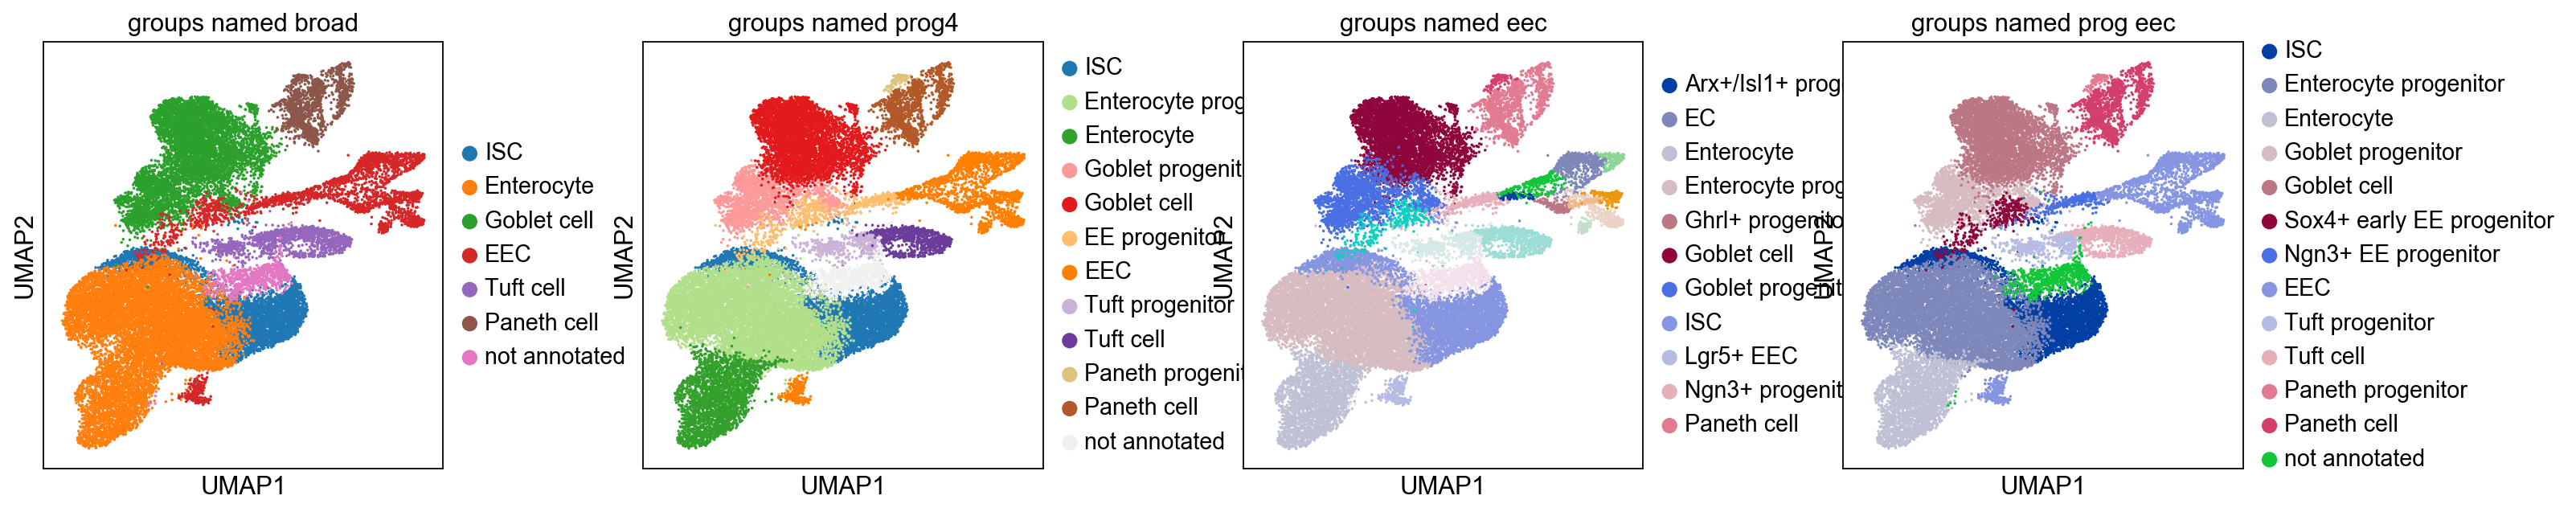

In [119]:
sc.pl.umap(adata_all_hvg, color=['groups_named_broad', 'groups_named_prog4', 'groups_named_eec', 'groups_named_prog_eec'], size=10)

#### EEC subpopulations

few notes:  
- 9,6,1 potentially clusters with 9,6,0 because of a regionality (Onecut2 low) and because it expresses low Gcg. However the rest of the expression profile matches SIK and we therefore assign it to SIK
- 6,6 is similar to EC clusters and likely only forms a cluster due to regional differences (e.g. Onecut2 low).

In [120]:
map1 = {'Sox4+ early EE progenitor': ['0,1,1','5,2,1','5,2,3', '5,2,4'],
        'Ngn3+ progenitor': ['6,4','6,0,0','6,0,1,2'],
        'Arx+/Isl1+ progenitor': ['6,0,2','6,0,1,0'],
        'Pax4+ progenitor': ['6,0,3','6,3','6,0,1,1'],
        'Ghrl+ progenitor': ['9,1,0','9,1,1'],
        'SILA': ['9,4'],
        'SILP': ['9,2','9,6,0'],
        'SAKD': ['9,3'],
        'SIK': ['9,5','9,0','9,6,1'],
        'Reg4+ EC': ['6,5'],
        'EC': ['6,1','6,2','6,6'],
        'Lgr5+ EEC': ['11']}
class_map = {v: k for k,vv in map1.items() for v in vv}

In [121]:
adata_all_hvg.obs['groups_named_eec'] = [
            class_map[x] if x in class_map.keys() else z
            for x,z in zip(adata_all_hvg.obs['prog_eec_refined'].values, adata_all_hvg.obs['groups_named_prog4'].values)
        ]

In [122]:
adata_all_hvg.obs['groups_named_eec_final'] = adata_all_hvg.obs['groups_named_eec_final'].astype('category')
adata_all_hvg.obs['groups_named_eec_final'].cat.reorder_categories([
    'ISC','Enterocyte progenitor','Enterocyte', 'Goblet progenitor','Goblet cell', 'Tuft progenitor', 
    'Tuft cell', 'Paneth progenitor', 'Paneth cell', 'not annotated', 'Sox4+ early EE progenitor', 
    'Ngn3+ progenitor','Arx+/Isl1+ progenitor','Pax4+ progenitor', 'Ghrl+ progenitor', 'SILA', 'SILP', 
    'SAKD', 'SIK', 'Reg4+ EC', 'EC', 'Lgr5+ EEC'], inplace=True)

... storing 'groups_named_eec' as categorical


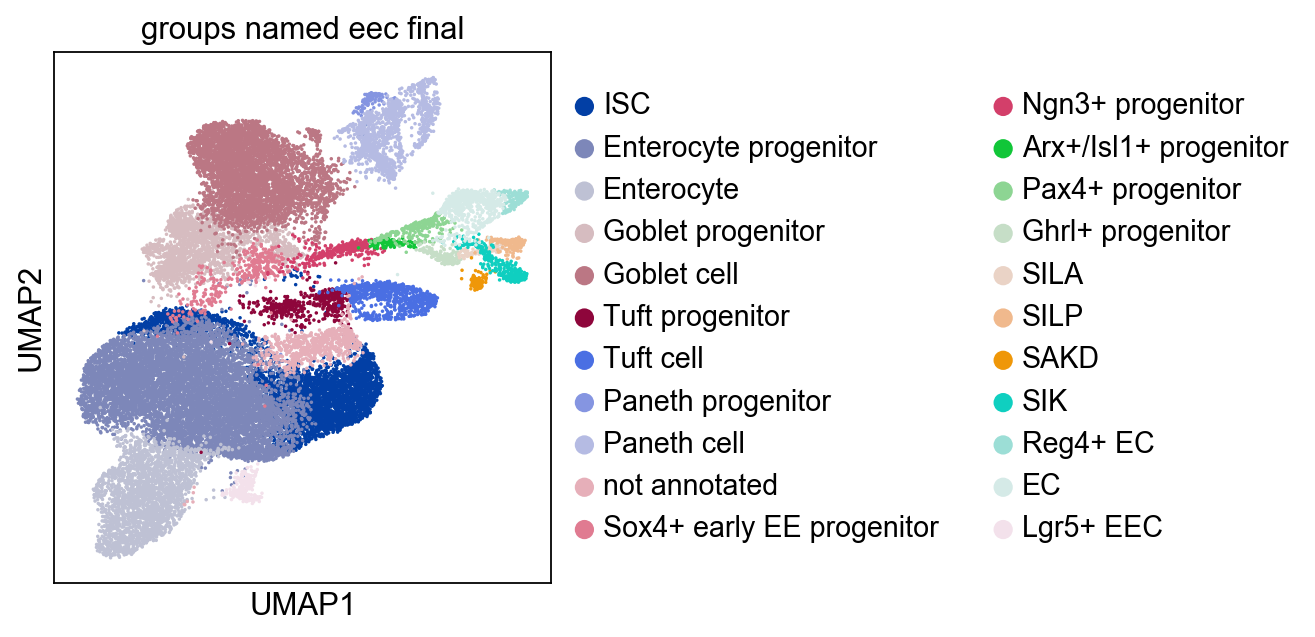

In [123]:
sc.pl.umap(adata_all_hvg, color=['groups_named_eec_final'], size=10)

### Identify regional subclusters

#### enterocyte

In [124]:
sc.tl.louvain(adata_all_hvg, restrict_to=('groups_named_prog4', ['Enterocyte']), key_added='entero_ref', resolution=0.3)

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.94) --> found 3 clusters and added
    'entero_ref', the cluster labels (adata.obs, categorical)


/Users/sophie/miniconda3/lib/python3.5/site-packages/pandas/core/indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
/Users/sophie/code/scanpy/scanpy/tools/louvain.py:131: FutureWarning: specifying 'categories' or 'ordered' in .astype() is deprecated; pass a CategoricalDtype instead
  'category', categories=natsorted(adata.obs[key_added].unique()))


In [125]:
map1 = {'Enterocyte (proximal)': ['Enterocyte,1', 'Enterocyte,0'], 
        'Enterocyte (distal)': ['Enterocyte,2']}
class_map = {v: k for k,vv in map1.items() for v in vv}

In [126]:
adata_all_hvg.obs['groups_named_regional'] = adata_all_hvg.obs['entero_ref']

adata_all_hvg.obs['groups_named_regional'] = [
            class_map[x] if x in class_map.keys() else x
            for x in adata_all_hvg.obs['groups_named_regional'].values
        ]
adata_all_hvg.obs['groups_named_regional'] = adata_all_hvg.obs['groups_named_regional'].astype('category')

#### enterocyte progenitor

In [127]:
sc.tl.louvain(adata_all_hvg, restrict_to=('groups_named_regional', ['Enterocyte progenitor']), key_added='entero_prog_ref', resolution=1.5)

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:01.86) --> found 16 clusters and added
    'entero_prog_ref', the cluster labels (adata.obs, categorical)


In [128]:
map1 = {'Enterocyte progenitor (proximal)': [
    'Enterocyte progenitor,0','Enterocyte progenitor,1','Enterocyte progenitor,2','Enterocyte progenitor,3','Enterocyte progenitor,4','Enterocyte progenitor,5',
    'Enterocyte progenitor,6','Enterocyte progenitor,7','Enterocyte progenitor,8','Enterocyte progenitor,10','Enterocyte progenitor,11',
    'Enterocyte progenitor,12','Enterocyte progenitor,13','Enterocyte progenitor,15'
],
        'Enterocyte progenitor (distal)': ['Enterocyte progenitor,9','Enterocyte progenitor,14']}
class_map = {v: k for k,vv in map1.items() for v in vv}

In [129]:
adata_all_hvg.obs['groups_named_regional'] = adata_all_hvg.obs['entero_prog_ref']

adata_all_hvg.obs['groups_named_regional'] = [
            class_map[x] if x in class_map.keys() else x
            for x in adata_all_hvg.obs['groups_named_regional'].values
        ]

In [131]:
adata_all_hvg.obs['groups_named_regional'] = adata_all_hvg.obs['groups_named_regional'].astype('category')

#### goblet cell

In [132]:
sc.tl.louvain(adata_all_hvg, restrict_to=('groups_named_regional',['Goblet cell']), key_added='goblet_ref', resolution=0.255)

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:01.76) --> found 4 clusters and added
    'goblet_ref', the cluster labels (adata.obs, categorical)


In [133]:
map1 = {'Goblet cell (proximal)': ['Goblet cell,0', 'Goblet cell,2'],
        'Goblet cell (distal)': ['Goblet cell,1','Goblet cell,3']}
class_map = {v: k for k,vv in map1.items() for v in vv}

In [134]:
adata_all_hvg.obs['groups_named_regional'] = adata_all_hvg.obs['goblet_ref']

adata_all_hvg.obs['groups_named_regional'] = [
            class_map[x] if x in class_map.keys() else x
            for x in adata_all_hvg.obs['groups_named_regional'].values
        ]

#### goblet progenitor

In [135]:
sc.tl.louvain(adata_all_hvg,restrict_to=('prog_refined_5',['5,0']), key_added='goblet_prog_ref3', resolution=2.2)
sc.tl.louvain(adata_all_hvg,restrict_to=('goblet_prog_ref3',['5,1']), key_added='goblet_prog_ref4', resolution=2)

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.30) --> found 16 clusters and added
    'goblet_prog_ref3', the cluster labels (adata.obs, categorical)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.27) --> found 14 clusters and added
    'goblet_prog_ref4', the cluster labels (adata.obs, categorical)


In [136]:
ref_cluster = np.array(adata_all_hvg.obs['groups_named_regional'])

ref_goblet = adata_all_hvg.obs['goblet_prog_ref4']
ix = np.isin(ref_goblet, ['5,0,3', '5,0,5', '5,0,7', '5,0,12', '5,0,13', '5,0,5', '5,1,1', '5,1,6', '5,1,10', '5,2,0', '5,1,11'])
ref_cluster[ix] = 'Goblet progenitor (distal)'

ref_goblet = adata_all_hvg.obs['goblet_prog_ref4']
ix = np.isin(ref_goblet,['5,0,0','5,0,1','5,0,2','5,0,4','5,0,6','5,0,8','5,0,9','5,0,10','5,0,11','5,0,14','5,0,15','5,1,0', 
                         '5,1,2','5,1,3','5,1,4','5,1,5','5,1,7','5,1,8','5,1,9','5,1,12','5,1,13','5,2,2'])
ref_cluster[ix]='Goblet progenitor (proximal)'


adata_all_hvg.obs['groups_named_regional'] = ref_cluster

adata_all_hvg.obs['groups_named_regional'] = adata_all_hvg.obs['groups_named_regional'].astype('category')

#### ISC

In [138]:
sc.tl.louvain(adata_all_hvg, restrict_to=('groups_named_regional',['ISC']), key_added='isc_ref', resolution=1)

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.90) --> found 9 clusters and added
    'isc_ref', the cluster labels (adata.obs, categorical)


In [139]:
map1 = {'ISC (proximal)': ['ISC,1','ISC,2','ISC,4','ISC,7','ISC,8'],
        'ISC (distal)': ['ISC,0','ISC,3','ISC,5','ISC,6']}
class_map = {v: k for k,vv in map1.items() for v in vv}

In [140]:
adata_all_hvg.obs['groups_named_regional'] = adata_all_hvg.obs['isc_ref']

adata_all_hvg.obs['groups_named_regional'] = [
            class_map[x] if x in class_map.keys() else x
            for x in adata_all_hvg.obs['groups_named_regional'].values
        ]

In [142]:
adata_all_hvg.obs['groups_named_regional'] = adata_all_hvg.obs['groups_named_regional'].astype('category')

with EE progenitors

In [143]:
# add and separate endocrine progenitor from a finer EEC clustering
map1 = {'Sox4+ early EE progenitor': ['0,1,1', '5,2,1', '5,2,3', '5,2,4'],
        'Ngn3+ EE progenitor': ['6,4','6,0,0','6,0,1,2']}
class_map = {v: k for k,vv in map1.items() for v in vv}

In [144]:
adata_all_hvg.obs['groups_named_regional_eec'] = [
            class_map[x] if x in class_map.keys() else z
            for x,z in zip(adata_all_hvg.obs['prog_eec_refined'].values, adata_all_hvg.obs['groups_named_regional'].values)
        ]

In [146]:
adata_all_hvg.obs['groups_named_regional_eec'] = adata_all_hvg.obs['groups_named_regional_eec'].astype('category')
adata_all_hvg.obs['groups_named_regional_eec'].cat.reorder_categories([
    'ISC (proximal)','ISC (distal)', 'Enterocyte progenitor (proximal)','Enterocyte progenitor (distal)',
    'Enterocyte (proximal)','Enterocyte (distal)', 'Goblet progenitor (proximal)',
    'Goblet progenitor (distal)', 'Goblet cell (proximal)','Goblet cell (distal)', 'Sox4+ early EE progenitor', 
    'Ngn3+ EE progenitor', 'EEC', 'Tuft progenitor', 'Tuft cell','Paneth progenitor','Paneth cell','not annotated'
], 
    inplace=True)

#### grouping by regional annotation

In [147]:
map1 = {'proximal': [
            'Enterocyte progenitor (proximal)', 'Enterocyte (proximal)', 'ISC (proximal)', 
            'Goblet progenitor (proximal)', 'Goblet cell (proximal)'
        ],
        'distal': [
            'Enterocyte progenitor (distal)', 'Enterocyte (distal)', 'ISC (distal)', 
            'Goblet progenitor (distal)', 'Goblet cell (distal)'
        ]
       }

class_map = {v: k for k,vv in map1.items() for v in vv}

In [148]:
adata_all_hvg.obs['groups_named_regional_only'] = adata_all_hvg.obs['groups_named_regional']

adata_all_hvg.obs['groups_named_regional_only'] = [
            class_map[x] if x in class_map.keys() else 'other'
            for x in adata_all_hvg.obs['groups_named_regional_only'].values
        ]

In [149]:
adata_all_hvg.obs['groups_named_regional_only'] = adata_all_hvg.obs['groups_named_regional_only'].astype('category')
adata_all_hvg.obs['groups_named_regional_only'].cat.reorder_categories(['proximal', 'distal', 'other'], inplace=True)

In [150]:
adata_all_hvg.uns['groups_named_regional_only_colors']=['#1c9099','#a6bddb','#f0f0f0']

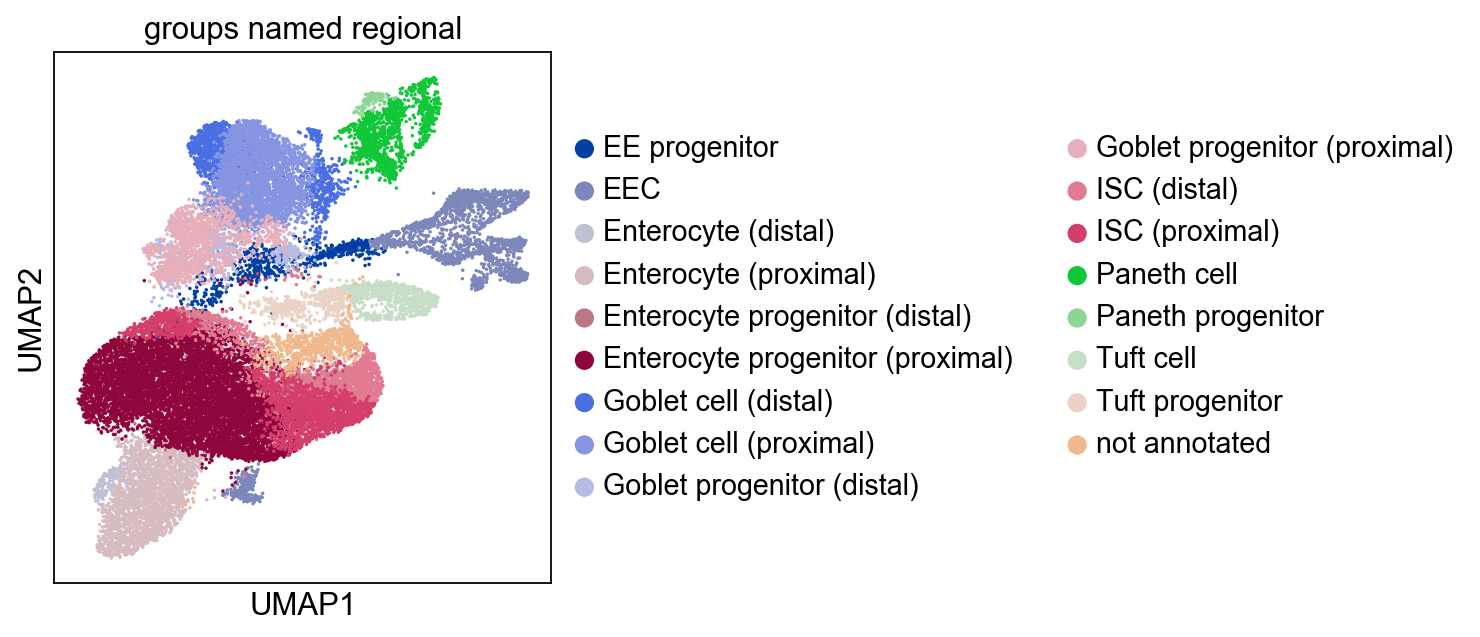

In [151]:
sc.pl.umap(adata_all_hvg, color=['groups_named_regional'], size=10)

## Save annotated data

In [152]:
adata_all.obs['groups_named_broad'] = adata_all_hvg.obs['groups_named_broad']
adata_all.obs['groups_named_prog4'] = adata_all_hvg.obs['groups_named_prog4']
adata_all.obs['groups_named_regional'] = adata_all_hvg.obs['groups_named_regional']
adata_all.obs['groups_named_regional_only'] = adata_all_hvg.obs['groups_named_regional_only']
adata_all.obs['groups_named_eec_final'] = adata_all_hvg.obs['groups_named_eec_final']
adata_all.obs['groups_named_prog_eec'] = adata_all_hvg.obs['groups_named_prog_eec']

adata_all.uns['groups_named_prog4_colors']=adata_all_hvg.uns['groups_named_prog4_colors']
adata_all.uns['groups_named_regional_only_colors']=adata_all_hvg.uns['groups_named_regional_only_colors']

In [153]:
# add hvg annotation to full adata for GEO submission
adata_all.var['highly_variable'] = [True if gene in adata_all_hvg.var_names else False for gene in adata_all.var_names]

In [ ]:
sc.write('./data/adata_processed.h5', adata_all)
#sc.write('./data/adata_processed_hvg.h5', adata_all_hvg)